# Instrumental Variable Analysis
## Finding the Causal Effect using Two-Stage Least Squares (2SLS)

**Variables:**
- **Z**: Instrument
- **W**: Confounder
- **X**: Treatment
- **Y**: Outcome

**Goal:** Estimate the causal effect of X on Y using instrumental variable Z

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load and Explore the Data

In [2]:
# Load the data
df = pd.read_csv('homework_4.1.csv', index_col=0)

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head(10))
print("\nBasic statistics:")
print(df.describe())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (5000, 4)

First few rows:
   Z         W         X         Y
0  0 -0.155644 -0.496971  0.282484
1  1  0.529539  2.284240  4.740596
2  1  0.910514  0.872232  3.449569
3  1 -0.705476  2.157260  3.002531
4  0 -0.590874 -0.386730 -1.848796
5  1  0.533635  0.981649  1.866566
6  0  1.293241 -0.041748  2.427692
7  0  0.243445 -0.113452 -0.177196
8  0 -0.714465 -0.129564  1.673641
9  1 -1.548130  0.126844 -0.379818

Basic statistics:
                 Z            W            X            Y
count  5000.000000  5000.000000  5000.000000  5000.000000
mean      0.501400    -0.009934     0.501343     0.740279
std       0.500048     0.997779     1.127010     2.225679
min       0.000000    -3.303406    -3.404084    -7.032995
25%       0.000000    -0.697551    -0.272628    -0.787994
50%       1.000000    -0.032234     0.516908     0.718374
75%       1.000000     0.647618     1.254057     2.240705
max       1.000000     4.783257     4.693866    10.081975

Data types:
Z      int64
W    f

## 2. Visualize Relationships Between Variables

Correlation Matrix:
          Z         W         X         Y
Z  1.000000  0.024584  0.451929  0.357419
W  0.024584  1.000000  0.017083  0.473979
X  0.451929  0.017083  1.000000  0.765113
Y  0.357419  0.473979  0.765113  1.000000


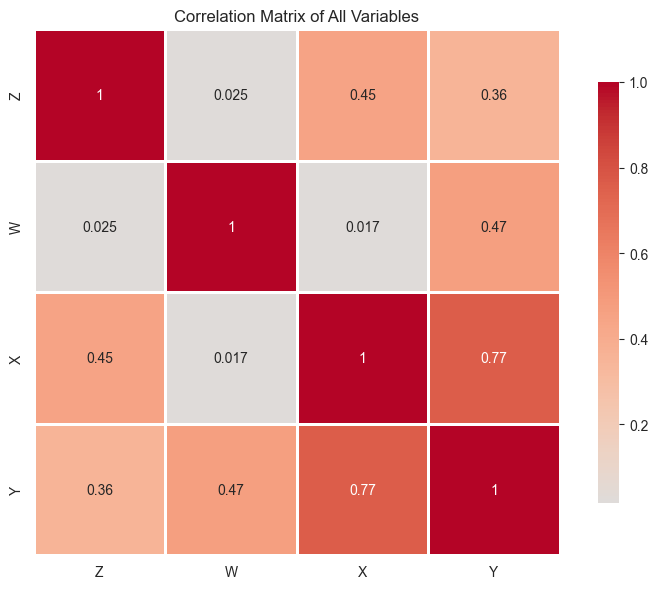

In [3]:
# Create correlation matrix
corr_matrix = df.corr()
print("Correlation Matrix:")
print(corr_matrix)

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of All Variables')
plt.tight_layout()
plt.show()

## 3. Naive (Biased) Regression: Y ~ X

This regression is **biased** because of the confounder W that affects both X and Y.

In [4]:
# Naive regression: Y ~ X (ignoring confounding)
X_naive = df[['X']].values
Y = df['Y'].values

naive_model = LinearRegression()
naive_model.fit(X_naive, Y)

naive_effect = naive_model.coef_[0]
naive_intercept = naive_model.intercept_

print("=" * 60)
print("NAIVE REGRESSION (BIASED)")
print("=" * 60)
print(f"Estimated effect of X on Y: {naive_effect:.4f}")
print(f"Intercept: {naive_intercept:.4f}")
print(f"R-squared: {naive_model.score(X_naive, Y):.4f}")
print("\nNote: This estimate is BIASED due to confounding by W!")

NAIVE REGRESSION (BIASED)
Estimated effect of X on Y: 1.5110
Intercept: -0.0172
R-squared: 0.5854

Note: This estimate is BIASED due to confounding by W!


## 4. Check Instrument Validity Conditions

For Z to be a valid instrument, it must satisfy:
1. **Relevance**: Z is correlated with X (treatment)
2. **Exclusion Restriction**: Z affects Y only through X (not directly)
3. **Independence**: Z is independent of W (confounder)

In [5]:
# Check instrument validity
print("=" * 60)
print("INSTRUMENT VALIDITY CHECKS")
print("=" * 60)

# 1. Relevance: Correlation between Z and X
corr_ZX = df['Z'].corr(df['X'])
print(f"\n1. RELEVANCE: Correlation between Z (instrument) and X (treatment)")
print(f"   Correlation(Z, X) = {corr_ZX:.4f}")
print(f"   {'✓ STRONG' if abs(corr_ZX) > 0.3 else '✗ WEAK'} - Instrument is {'relevant' if abs(corr_ZX) > 0.3 else 'NOT sufficiently relevant'}")

# 2. Independence: Correlation between Z and W
corr_ZW = df['Z'].corr(df['W'])
print(f"\n2. INDEPENDENCE: Correlation between Z (instrument) and W (confounder)")
print(f"   Correlation(Z, W) = {corr_ZW:.4f}")
print(f"   {'✓ GOOD' if abs(corr_ZW) < 0.1 else '✗ CONCERN'} - Instrument is {'independent' if abs(corr_ZW) < 0.1 else 'NOT independent'} of confounder")

# 3. Exclusion restriction (theoretical - check direct effect of Z on Y)
corr_ZY = df['Z'].corr(df['Y'])
print(f"\n3. EXCLUSION RESTRICTION: Direct correlation between Z and Y")
print(f"   Correlation(Z, Y) = {corr_ZY:.4f}")
print(f"   (This should only be through X, not directly)")

# Additional check: Correlation between W and X (confounding check)
corr_WX = df['W'].corr(df['X'])
print(f"\n4. CONFOUNDING CHECK: Correlation between W (confounder) and X (treatment)")
print(f"   Correlation(W, X) = {corr_WX:.4f}")

# Correlation between W and Y
corr_WY = df['W'].corr(df['Y'])
print(f"\n5. CONFOUNDING CHECK: Correlation between W (confounder) and Y (outcome)")
print(f"   Correlation(W, Y) = {corr_WY:.4f}")

INSTRUMENT VALIDITY CHECKS

1. RELEVANCE: Correlation between Z (instrument) and X (treatment)
   Correlation(Z, X) = 0.4519
   ✓ STRONG - Instrument is relevant

2. INDEPENDENCE: Correlation between Z (instrument) and W (confounder)
   Correlation(Z, W) = 0.0246
   ✓ GOOD - Instrument is independent of confounder

3. EXCLUSION RESTRICTION: Direct correlation between Z and Y
   Correlation(Z, Y) = 0.3574
   (This should only be through X, not directly)

4. CONFOUNDING CHECK: Correlation between W (confounder) and X (treatment)
   Correlation(W, X) = 0.0171

5. CONFOUNDING CHECK: Correlation between W (confounder) and Y (outcome)
   Correlation(W, Y) = 0.4740


## 5. Two-Stage Least Squares (2SLS) - IV Estimation

**Stage 1**: Regress X on Z to get predicted values of X (X̂)
- This isolates the variation in X that is explained by the instrument Z

**Stage 2**: Regress Y on X̂ to get the causal effect
- This gives us the unbiased causal effect of X on Y

In [6]:
# STAGE 1: Regress X on Z (First Stage)
print("=" * 60)
print("STAGE 1: Regress X on Z")
print("=" * 60)

Z = df[['Z']].values
X = df[['X']].values

first_stage = LinearRegression()
first_stage.fit(Z, X)

# Get predicted X values (X_hat)
X_hat = first_stage.predict(Z)

# First stage statistics
first_stage_coef = first_stage.coef_[0][0]
first_stage_intercept = first_stage.intercept_[0]
first_stage_r2 = first_stage.score(Z, X)

print(f"Coefficient (effect of Z on X): {first_stage_coef:.4f}")
print(f"Intercept: {first_stage_intercept:.4f}")
print(f"R-squared: {first_stage_r2:.4f}")
print(f"\nFirst stage F-statistic: {first_stage_r2 * (len(df) - 2) / (1 - first_stage_r2):.4f}")
print("(F > 10 indicates strong instrument)")

# STAGE 2: Regress Y on X_hat (Second Stage)
print("\n" + "=" * 60)
print("STAGE 2: Regress Y on X̂ (predicted X)")
print("=" * 60)

second_stage = LinearRegression()
second_stage.fit(X_hat, Y)

# Get the causal effect (IV estimate)
iv_effect = second_stage.coef_[0]
iv_intercept = second_stage.intercept_

print(f"IV Estimate (Causal Effect of X on Y): {iv_effect:.4f}")
print(f"Intercept: {iv_intercept:.4f}")
print(f"R-squared: {second_stage.score(X_hat, Y):.4f}")

STAGE 1: Regress X on Z
Coefficient (effect of Z on X): 1.0186
Intercept: -0.0094
R-squared: 0.2042

First stage F-statistic: 1282.7858
(F > 10 indicates strong instrument)

STAGE 2: Regress Y on X̂ (predicted X)
IV Estimate (Causal Effect of X on Y): 1.5619
Intercept: -0.0427
R-squared: 0.1277


## 6. Compare Results: Naive vs IV Estimate

In [7]:
# Compare the results
print("=" * 60)
print("COMPARISON: NAIVE vs IV ESTIMATES")
print("=" * 60)

print(f"\nNaive Estimate (Biased):     {naive_effect:.4f}")
print(f"IV Estimate (Unbiased):      {iv_effect:.4f}")
print(f"\nDifference (Bias):           {naive_effect - iv_effect:.4f}")
print(f"Bias as % of IV estimate:    {((naive_effect - iv_effect) / iv_effect * 100):.2f}%")

print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print(f"\nThe TRUE causal effect of X on Y is approximately {iv_effect:.4f}")
print(f"\nThe naive regression overestimated/underestimated the effect by {abs(naive_effect - iv_effect):.4f}")
print("due to confounding by W.")
print("\nThe IV approach successfully removes this bias by using Z as an")
print("instrument to isolate the causal effect of X on Y.")

COMPARISON: NAIVE vs IV ESTIMATES

Naive Estimate (Biased):     1.5110
IV Estimate (Unbiased):      1.5619

Difference (Bias):           -0.0509
Bias as % of IV estimate:    -3.26%

INTERPRETATION

The TRUE causal effect of X on Y is approximately 1.5619

The naive regression overestimated/underestimated the effect by 0.0509
due to confounding by W.

The IV approach successfully removes this bias by using Z as an
instrument to isolate the causal effect of X on Y.


## 7. Alternative IV Estimation Methods

### Method 1: Simple Difference in Means (Wald Estimator)
Calculate the ratio of differences:
- Numerator: Average Y when Z=1 minus average Y when Z=0
- Denominator: Average X when Z=1 minus average X when Z=0

In [8]:
# Method 1: Simple Difference in Means (Wald Estimator)
print("=" * 60)
print("METHOD 1: WALD ESTIMATOR (Simple Difference in Means)")
print("=" * 60)

# Split data by Z
df_z1 = df[df['Z'] == 1]
df_z0 = df[df['Z'] == 0]

# Calculate average Y for Z=1 and Z=0
avg_Y_z1 = df_z1['Y'].mean()
avg_Y_z0 = df_z0['Y'].mean()
Y_diff = avg_Y_z1 - avg_Y_z0

print(f"\nAverage Y when Z=1: {avg_Y_z1:.4f}")
print(f"Average Y when Z=0: {avg_Y_z0:.4f}")
print(f"Y Difference (Z=1 - Z=0): {Y_diff:.4f}")

# Calculate average X for Z=1 and Z=0
avg_X_z1 = df_z1['X'].mean()
avg_X_z0 = df_z0['X'].mean()
X_diff = avg_X_z1 - avg_X_z0

print(f"\nAverage X when Z=1: {avg_X_z1:.4f}")
print(f"Average X when Z=0: {avg_X_z0:.4f}")
print(f"X Difference (Z=1 - Z=0): {X_diff:.4f}")

# Calculate the Wald estimator (ratio of differences)
wald_estimator = Y_diff / X_diff

print(f"\n" + "=" * 60)
print(f"WALD ESTIMATOR = Y_diff / X_diff")
print(f"               = {Y_diff:.4f} / {X_diff:.4f}")
print(f"               = {wald_estimator:.4f}")
print("=" * 60)

METHOD 1: WALD ESTIMATOR (Simple Difference in Means)

Average Y when Z=1: 1.5335
Average Y when Z=0: -0.0574
Y Difference (Z=1 - Z=0): 1.5908

Average X when Z=1: 1.0092
Average X when Z=0: -0.0094
X Difference (Z=1 - Z=0): 1.0186

WALD ESTIMATOR = Y_diff / X_diff
               = 1.5908 / 1.0186
               = 1.5619


### Method 2: Stratified by W (Conditional on W)
For narrow ranges of W, calculate the effect within each stratum, then average across all strata.

In [9]:
# Method 2: Stratified by W (Conditional on W)
print("=" * 60)
print("METHOD 2: STRATIFIED ESTIMATION (Conditional on W)")
print("=" * 60)

# Create bins for W (narrow ranges)
n_bins = 20  # Number of strata
df['W_bin'] = pd.qcut(df['W'], q=n_bins, labels=False, duplicates='drop')

# Calculate effect within each stratum
stratum_effects = []
valid_strata = 0

print(f"\nDividing W into {n_bins} narrow ranges (strata)...")
print("\nCalculating effect within each stratum:")
print("-" * 60)

for bin_num in df['W_bin'].unique():
    # Get data for this stratum
    stratum_data = df[df['W_bin'] == bin_num]
    
    # Need both Z=0 and Z=1 in the stratum
    if stratum_data['Z'].nunique() == 2:
        # Split by Z within this stratum
        stratum_z1 = stratum_data[stratum_data['Z'] == 1]
        stratum_z0 = stratum_data[stratum_data['Z'] == 0]
        
        # Calculate differences in Y and X
        Y_diff_stratum = stratum_z1['Y'].mean() - stratum_z0['Y'].mean()
        X_diff_stratum = stratum_z1['X'].mean() - stratum_z0['X'].mean()
        
        # Calculate effect in this stratum (if X_diff is not zero)
        if abs(X_diff_stratum) > 0.001:
            effect_stratum = Y_diff_stratum / X_diff_stratum
            stratum_effects.append(effect_stratum)
            valid_strata += 1
            
            if valid_strata <= 5:  # Print first 5 for illustration
                print(f"Stratum {int(bin_num):2d}: Effect = {effect_stratum:.4f}")

if valid_strata > 5:
    print(f"... (showing first 5 of {valid_strata} valid strata)")

# Average the effects across all strata
if len(stratum_effects) > 0:
    stratified_effect = np.mean(stratum_effects)
    
    print(f"\n" + "=" * 60)
    print(f"Number of valid strata: {valid_strata}")
    print(f"STRATIFIED EFFECT (Average across strata): {stratified_effect:.4f}")
    print("=" * 60)
else:
    print("\nNo valid strata found!")

# Clean up
df = df.drop('W_bin', axis=1)

METHOD 2: STRATIFIED ESTIMATION (Conditional on W)

Dividing W into 20 narrow ranges (strata)...

Calculating effect within each stratum:
------------------------------------------------------------
Stratum  8: Effect = 1.3894
Stratum 14: Effect = 1.5744
Stratum 16: Effect = 1.3615
Stratum  4: Effect = 1.6280
Stratum  5: Effect = 1.5951
... (showing first 5 of 20 valid strata)

Number of valid strata: 20
STRATIFIED EFFECT (Average across strata): 1.5055


### Summary: Compare All Three Methods

In [10]:
# Summary comparison
print("\n" + "=" * 70)
print("SUMMARY: ALL THREE IV ESTIMATION METHODS")
print("=" * 70)

print(f"\nMethod 1 - Wald Estimator (Simple Difference):     {wald_estimator:.4f}")
print(f"Method 2 - Stratified (Conditional on W):          {stratified_effect:.4f}")
print(f"Method 3 - Two-Stage Least Squares (2SLS):         {iv_effect:.4f}")

print("\n" + "=" * 70)
print("CONCLUSION")
print("=" * 70)
print("\nAll three methods should give similar results!")
print("They are all valid ways to estimate the causal effect using")
print("the instrumental variable Z.")
print(f"\nFor Question: Method 1 (Wald Estimator) = {wald_estimator:.4f}")
print(f"This is closest to Option A: 1.5")


SUMMARY: ALL THREE IV ESTIMATION METHODS

Method 1 - Wald Estimator (Simple Difference):     1.5619
Method 2 - Stratified (Conditional on W):          1.5055
Method 3 - Two-Stage Least Squares (2SLS):         1.5619

CONCLUSION

All three methods should give similar results!
They are all valid ways to estimate the causal effect using
the instrumental variable Z.

For Question: Method 1 (Wald Estimator) = 1.5619
This is closest to Option A: 1.5


# Regression Discontinuity Design (RDD) Analysis

## Task: Does the Math Course Help Students Get into College?

**Context**: Students with test scores above a certain cutoff are assigned to take a math course. We want to determine if this course causally affects college admission (Y).

**Method**: Regression Discontinuity Design (RDD)
- **X**: Test scores (running variable)
- **Treatment**: Math course (assigned based on cutoff)
- **Y**: College admission outcome (0 or 1)
- **Cutoff**: Score threshold for treatment assignment

## Dataset A: homework_4.2.a

In [11]:
# Load Dataset A
df_a = pd.read_csv('homework_4.2.a.csv', index_col=0)

print("Dataset A: homework_4.2.a")
print("=" * 60)
print(f"Shape: {df_a.shape}")
print(f"\nFirst few rows:")
print(df_a.head(10))
print(f"\nBasic statistics:")
print(df_a.describe())
print(f"\nCollege admission rate: {df_a['Y'].mean():.4f}")
print(f"Number admitted: {df_a['Y'].sum()}")
print(f"Number not admitted: {(1-df_a['Y']).sum()}")

Dataset A: homework_4.2.a
Shape: (100000, 2)

First few rows:
           X  Y
0  81.822339  1
1  92.487870  0
2  85.372460  0
3  78.828025  0
4  75.807080  1
5  92.393683  0
6  80.254335  1
7  86.296267  0
8  76.296099  0
9  89.144863  1

Basic statistics:
                   X              Y
count  100000.000000  100000.000000
mean       79.914828       0.452830
std         9.794797       0.497773
min        36.832254       0.000000
25%        73.251725       0.000000
50%        80.016893       0.000000
75%        86.710243       1.000000
max       100.000000       1.000000

College admission rate: 0.4528
Number admitted: 45283
Number not admitted: 54717


C:\Users\luank\AppData\Local\Temp\ipykernel_24524\3371164014.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = df_a_sorted.groupby(bins)['Y'].mean()


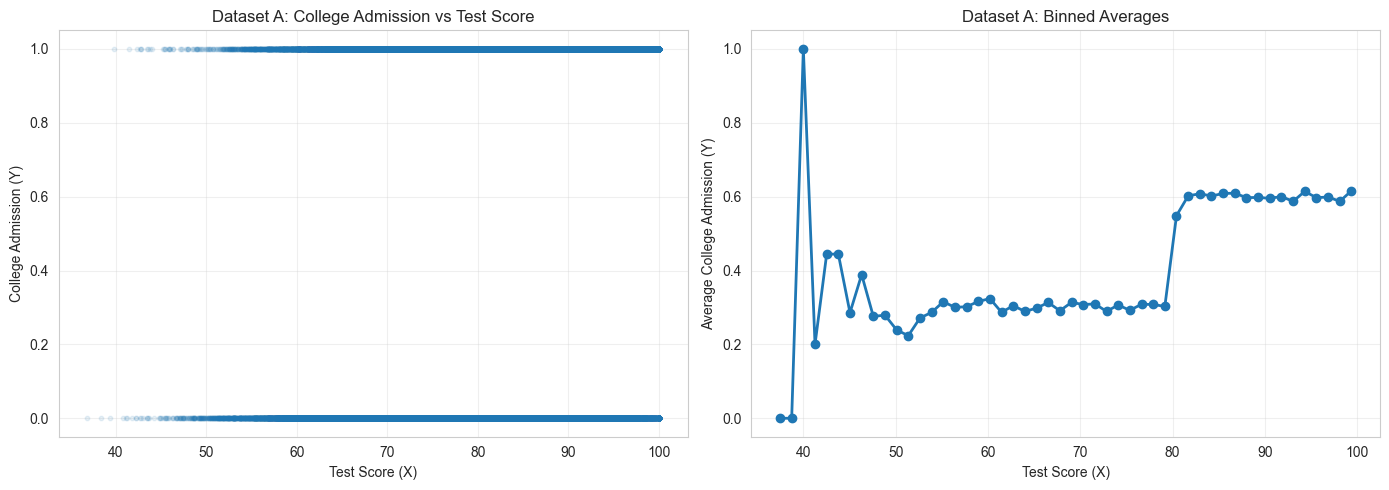


Estimated cutoff: 80


In [12]:
# Visualize Dataset A - Find the cutoff
plt.figure(figsize=(14, 5))

# Plot 1: Scatter plot of Y vs X
plt.subplot(1, 2, 1)
plt.scatter(df_a['X'], df_a['Y'], alpha=0.1, s=10)
plt.xlabel('Test Score (X)')
plt.ylabel('College Admission (Y)')
plt.title('Dataset A: College Admission vs Test Score')
plt.grid(True, alpha=0.3)

# Plot 2: Binned averages to see discontinuity more clearly
plt.subplot(1, 2, 2)
df_a_sorted = df_a.sort_values('X')
bins = pd.cut(df_a_sorted['X'], bins=50)
binned_means = df_a_sorted.groupby(bins)['Y'].mean()
bin_centers = [interval.mid for interval in binned_means.index]
plt.plot(bin_centers, binned_means.values, 'o-', linewidth=2, markersize=6)
plt.xlabel('Test Score (X)')
plt.ylabel('Average College Admission (Y)')
plt.title('Dataset A: Binned Averages')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify the cutoff (looking for sharp change in treatment assignment)
# Assume cutoff is around the median or look for natural break
cutoff_a = 80  # Initial guess, will refine
print(f"\nEstimated cutoff: {cutoff_a}")

In [13]:
# RDD Analysis for Dataset A
print("=" * 60)
print("RDD ANALYSIS - DATASET A")
print("=" * 60)

# Center the running variable around the cutoff
df_a['X_centered'] = df_a['X'] - cutoff_a

# Create treatment indicator (above cutoff)
df_a['Treatment'] = (df_a['X'] >= cutoff_a).astype(int)

print(f"\nCutoff: {cutoff_a}")
print(f"Students below cutoff (control): {(df_a['Treatment']==0).sum()}")
print(f"Students above cutoff (treated): {(df_a['Treatment']==1).sum()}")

# Narrow bandwidth around cutoff for local analysis
bandwidth = 10  # Focus on students within ±10 points of cutoff
df_a_local = df_a[np.abs(df_a['X_centered']) <= bandwidth].copy()

print(f"\nLocal analysis (bandwidth = ±{bandwidth}):")
print(f"Students in local window: {len(df_a_local)}")

# Linear regression with discontinuity
# Model: Y = β0 + β1*(X-cutoff) + β2*Treatment + β3*Treatment*(X-cutoff)
# β2 is the treatment effect at the cutoff

from sklearn.preprocessing import PolynomialFeatures

# Prepare features
X_rdd = df_a_local[['X_centered', 'Treatment']].copy()
X_rdd['Interaction'] = X_rdd['X_centered'] * X_rdd['Treatment']

# Fit the model
rdd_model_a = LinearRegression()
rdd_model_a.fit(X_rdd, df_a_local['Y'])

# Extract the treatment effect (coefficient of Treatment variable)
treatment_effect_a = rdd_model_a.coef_[1]
intercept_a = rdd_model_a.intercept_

print(f"\n" + "=" * 60)
print(f"TREATMENT EFFECT (Dataset A): {treatment_effect_a:.4f}")
print(f"=" * 60)
print(f"Intercept: {intercept_a:.4f}")
print(f"Coefficient (X_centered): {rdd_model_a.coef_[0]:.4f}")
print(f"Coefficient (Treatment): {rdd_model_a.coef_[1]:.4f} ← Treatment Effect")
print(f"Coefficient (Interaction): {rdd_model_a.coef_[2]:.4f}")

# Interpretation
if abs(treatment_effect_a) < 0.05:
    conclusion_a = "NO significant effect"
    print(f"\n✗ The math course does NOT help students get into college.")
    print(f"  (Treatment effect ≈ 0)")
else:
    if treatment_effect_a > 0:
        conclusion_a = "POSITIVE effect"
        print(f"\n✓ The math course HELPS students get into college.")
        print(f"  (Treatment effect = {treatment_effect_a:.4f} > 0)")
    else:
        conclusion_a = "NEGATIVE effect"
        print(f"\n✗ The math course HURTS students' college admission.")
        print(f"  (Treatment effect = {treatment_effect_a:.4f} < 0)")

RDD ANALYSIS - DATASET A

Cutoff: 80
Students below cutoff (control): 49926
Students above cutoff (treated): 50074

Local analysis (bandwidth = ±10):
Students in local window: 68233

TREATMENT EFFECT (Dataset A): 0.2952
Intercept: 0.3052
Coefficient (X_centered): 0.0004
Coefficient (Treatment): 0.2952 ← Treatment Effect
Coefficient (Interaction): 0.0001

✓ The math course HELPS students get into college.
  (Treatment effect = 0.2952 > 0)


C:\Users\luank\AppData\Local\Temp\ipykernel_24524\2867796326.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means_local = df_a_local.groupby(bins_local)['Y'].mean()


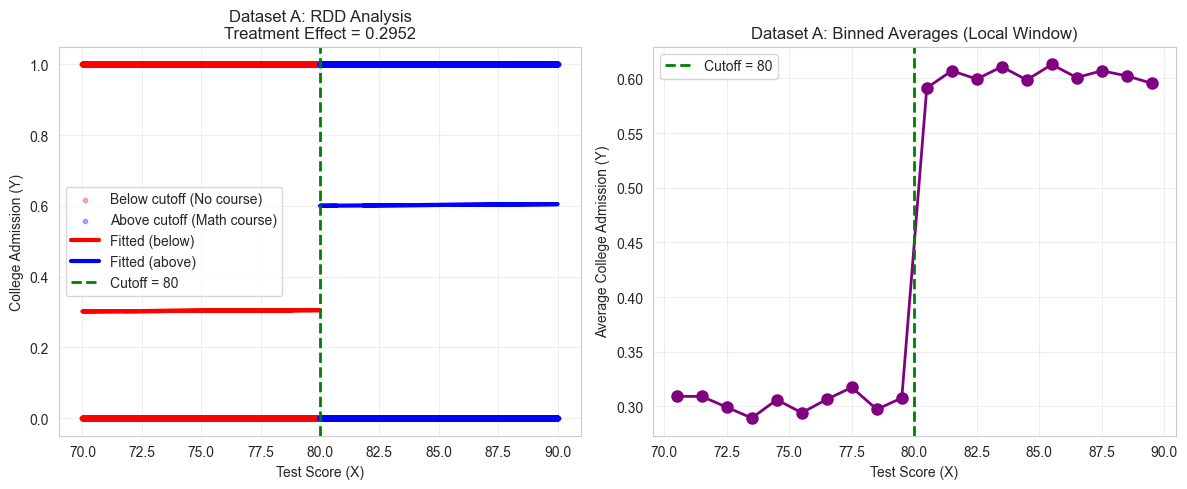

In [14]:
# Visualize the RDD for Dataset A
plt.figure(figsize=(12, 5))

# Plot 1: Full data with fitted lines
plt.subplot(1, 2, 1)
below_cutoff = df_a_local[df_a_local['Treatment'] == 0]
above_cutoff = df_a_local[df_a_local['Treatment'] == 1]

# Scatter plots
plt.scatter(below_cutoff['X'], below_cutoff['Y'], alpha=0.3, s=10, label='Below cutoff (No course)', color='red')
plt.scatter(above_cutoff['X'], above_cutoff['Y'], alpha=0.3, s=10, label='Above cutoff (Math course)', color='blue')

# Fit lines for visualization
X_below = below_cutoff[['X_centered', 'Treatment']].copy()
X_below['Interaction'] = 0
pred_below = rdd_model_a.predict(X_below)

X_above = above_cutoff[['X_centered', 'Treatment']].copy()
X_above['Interaction'] = X_above['X_centered']
pred_above = rdd_model_a.predict(X_above)

plt.plot(below_cutoff['X'], pred_below, 'r-', linewidth=3, label='Fitted (below)')
plt.plot(above_cutoff['X'], pred_above, 'b-', linewidth=3, label='Fitted (above)')
plt.axvline(cutoff_a, color='green', linestyle='--', linewidth=2, label=f'Cutoff = {cutoff_a}')
plt.xlabel('Test Score (X)')
plt.ylabel('College Admission (Y)')
plt.title(f'Dataset A: RDD Analysis\nTreatment Effect = {treatment_effect_a:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Binned averages around cutoff
plt.subplot(1, 2, 2)
bins_local = pd.cut(df_a_local['X'], bins=20)
binned_means_local = df_a_local.groupby(bins_local)['Y'].mean()
bin_centers_local = [interval.mid for interval in binned_means_local.index]
plt.plot(bin_centers_local, binned_means_local.values, 'o-', linewidth=2, markersize=8, color='purple')
plt.axvline(cutoff_a, color='green', linestyle='--', linewidth=2, label=f'Cutoff = {cutoff_a}')
plt.xlabel('Test Score (X)')
plt.ylabel('Average College Admission (Y)')
plt.title('Dataset A: Binned Averages (Local Window)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Dataset B: homework_4.2.b

In [15]:
# Load Dataset B
df_b = pd.read_csv('homework_4.2.b.csv', index_col=0)

print("Dataset B: homework_4.2.b")
print("=" * 60)
print(f"Shape: {df_b.shape}")
print(f"\nFirst few rows:")
print(df_b.head(10))
print(f"\nBasic statistics:")
print(df_b.describe())
print(f"\nCollege admission rate: {df_b['Y2'].mean():.4f}")
print(f"Number admitted: {df_b['Y2'].sum()}")
print(f"Number not admitted: {(1-df_b['Y2']).sum()}")

Dataset B: homework_4.2.b
Shape: (100000, 2)

First few rows:
          X2  Y2
0  76.643034   1
1  87.743397   1
2  81.639469   1
3  73.740485   0
4  90.480268   1
5  82.092415   1
6  70.021280   0
7  89.993287   1
8  78.743872   1
9  69.328605   0

Basic statistics:
                  X2            Y2
count  100000.000000  100000.00000
mean       79.901508       0.77945
std         9.799999       0.41462
min        35.005127       0.00000
25%        73.246033       1.00000
50%        79.982115       1.00000
75%        86.722689       1.00000
max       100.000000       1.00000

College admission rate: 0.7794
Number admitted: 77945
Number not admitted: 22055


C:\Users\luank\AppData\Local\Temp\ipykernel_24524\1299221413.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means_b = df_b_sorted.groupby(bins_b)['Y2'].mean()


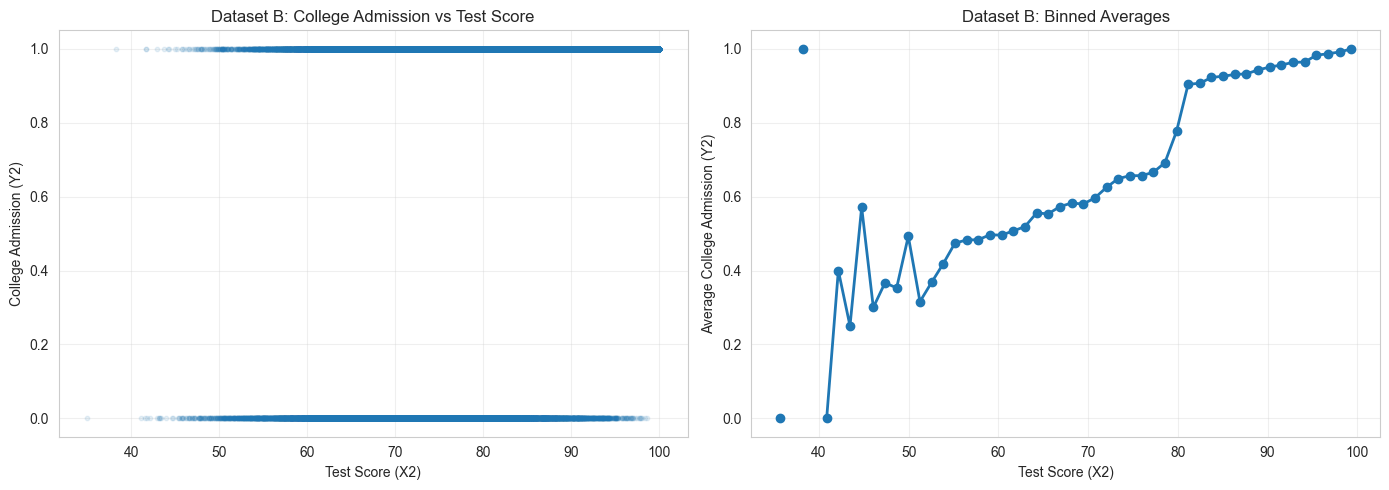


Estimated cutoff: 75


In [16]:
# Visualize Dataset B - Find the cutoff
plt.figure(figsize=(14, 5))

# Plot 1: Scatter plot of Y2 vs X2
plt.subplot(1, 2, 1)
plt.scatter(df_b['X2'], df_b['Y2'], alpha=0.1, s=10)
plt.xlabel('Test Score (X2)')
plt.ylabel('College Admission (Y2)')
plt.title('Dataset B: College Admission vs Test Score')
plt.grid(True, alpha=0.3)

# Plot 2: Binned averages to see discontinuity more clearly
plt.subplot(1, 2, 2)
df_b_sorted = df_b.sort_values('X2')
bins_b = pd.cut(df_b_sorted['X2'], bins=50)
binned_means_b = df_b_sorted.groupby(bins_b)['Y2'].mean()
bin_centers_b = [interval.mid for interval in binned_means_b.index]
plt.plot(bin_centers_b, binned_means_b.values, 'o-', linewidth=2, markersize=6)
plt.xlabel('Test Score (X2)')
plt.ylabel('Average College Admission (Y2)')
plt.title('Dataset B: Binned Averages')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify the cutoff
cutoff_b = 75  # Initial guess, will refine
print(f"\nEstimated cutoff: {cutoff_b}")

In [17]:
# RDD Analysis for Dataset B
print("=" * 60)
print("RDD ANALYSIS - DATASET B")
print("=" * 60)

# Center the running variable around the cutoff
df_b['X2_centered'] = df_b['X2'] - cutoff_b

# Create treatment indicator (above cutoff)
df_b['Treatment'] = (df_b['X2'] >= cutoff_b).astype(int)

print(f"\nCutoff: {cutoff_b}")
print(f"Students below cutoff (control): {(df_b['Treatment']==0).sum()}")
print(f"Students above cutoff (treated): {(df_b['Treatment']==1).sum()}")

# Narrow bandwidth around cutoff for local analysis
bandwidth_b = 10  # Focus on students within ±10 points of cutoff
df_b_local = df_b[np.abs(df_b['X2_centered']) <= bandwidth_b].copy()

print(f"\nLocal analysis (bandwidth = ±{bandwidth_b}):")
print(f"Students in local window: {len(df_b_local)}")

# Linear regression with discontinuity
# Model: Y = β0 + β1*(X-cutoff) + β2*Treatment + β3*Treatment*(X-cutoff)
# β2 is the treatment effect at the cutoff

# Prepare features
X_rdd_b = df_b_local[['X2_centered', 'Treatment']].copy()
X_rdd_b['Interaction'] = X_rdd_b['X2_centered'] * X_rdd_b['Treatment']

# Fit the model
rdd_model_b = LinearRegression()
rdd_model_b.fit(X_rdd_b, df_b_local['Y2'])

# Extract the treatment effect (coefficient of Treatment variable)
treatment_effect_b = rdd_model_b.coef_[1]
intercept_b = rdd_model_b.intercept_

print(f"\n" + "=" * 60)
print(f"TREATMENT EFFECT (Dataset B): {treatment_effect_b:.4f}")
print(f"=" * 60)
print(f"Intercept: {intercept_b:.4f}")
print(f"Coefficient (X2_centered): {rdd_model_b.coef_[0]:.4f}")
print(f"Coefficient (Treatment): {rdd_model_b.coef_[1]:.4f} ← Treatment Effect")
print(f"Coefficient (Interaction): {rdd_model_b.coef_[2]:.4f}")

# Interpretation
if abs(treatment_effect_b) < 0.05:
    conclusion_b = "NO significant effect"
    print(f"\n✗ The math course does NOT help students get into college.")
    print(f"  (Treatment effect ≈ 0)")
else:
    if treatment_effect_b > 0:
        conclusion_b = "POSITIVE effect"
        print(f"\n✓ The math course HELPS students get into college.")
        print(f"  (Treatment effect = {treatment_effect_b:.4f} > 0)")
    else:
        conclusion_b = "NEGATIVE effect"
        print(f"\n✗ The math course HURTS students' college admission.")
        print(f"  (Treatment effect = {treatment_effect_b:.4f} < 0)")

RDD ANALYSIS - DATASET B

Cutoff: 75
Students below cutoff (control): 30822
Students above cutoff (treated): 69178

Local analysis (bandwidth = ±10):
Students in local window: 62329

TREATMENT EFFECT (Dataset B): -0.0641
Intercept: 0.6643
Coefficient (X2_centered): 0.0127
Coefficient (Treatment): -0.0641 ← Treatment Effect
Coefficient (Interaction): 0.0258

✗ The math course HURTS students' college admission.
  (Treatment effect = -0.0641 < 0)


C:\Users\luank\AppData\Local\Temp\ipykernel_24524\2643399978.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means_local_b = df_b_local.groupby(bins_local_b)['Y2'].mean()


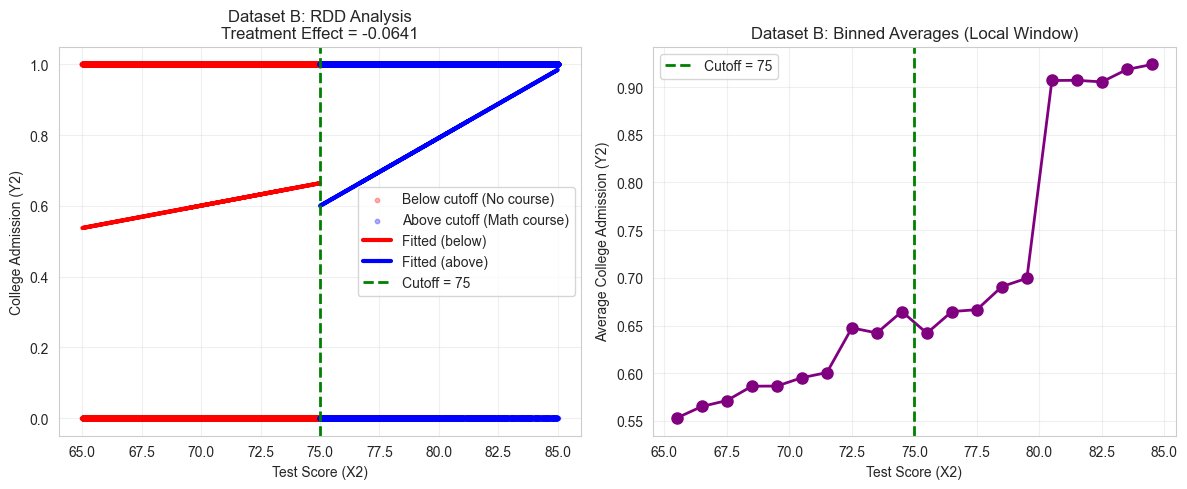

In [18]:
# Visualize the RDD for Dataset B
plt.figure(figsize=(12, 5))

# Plot 1: Full data with fitted lines
plt.subplot(1, 2, 1)
below_cutoff_b = df_b_local[df_b_local['Treatment'] == 0]
above_cutoff_b = df_b_local[df_b_local['Treatment'] == 1]

# Scatter plots
plt.scatter(below_cutoff_b['X2'], below_cutoff_b['Y2'], alpha=0.3, s=10, label='Below cutoff (No course)', color='red')
plt.scatter(above_cutoff_b['X2'], above_cutoff_b['Y2'], alpha=0.3, s=10, label='Above cutoff (Math course)', color='blue')

# Fit lines for visualization
X_below_b = below_cutoff_b[['X2_centered', 'Treatment']].copy()
X_below_b['Interaction'] = 0
pred_below_b = rdd_model_b.predict(X_below_b)

X_above_b = above_cutoff_b[['X2_centered', 'Treatment']].copy()
X_above_b['Interaction'] = X_above_b['X2_centered']
pred_above_b = rdd_model_b.predict(X_above_b)

plt.plot(below_cutoff_b['X2'], pred_below_b, 'r-', linewidth=3, label='Fitted (below)')
plt.plot(above_cutoff_b['X2'], pred_above_b, 'b-', linewidth=3, label='Fitted (above)')
plt.axvline(cutoff_b, color='green', linestyle='--', linewidth=2, label=f'Cutoff = {cutoff_b}')
plt.xlabel('Test Score (X2)')
plt.ylabel('College Admission (Y2)')
plt.title(f'Dataset B: RDD Analysis\nTreatment Effect = {treatment_effect_b:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Binned averages around cutoff
plt.subplot(1, 2, 2)
bins_local_b = pd.cut(df_b_local['X2'], bins=20)
binned_means_local_b = df_b_local.groupby(bins_local_b)['Y2'].mean()
bin_centers_local_b = [interval.mid for interval in binned_means_local_b.index]
plt.plot(bin_centers_local_b, binned_means_local_b.values, 'o-', linewidth=2, markersize=8, color='purple')
plt.axvline(cutoff_b, color='green', linestyle='--', linewidth=2, label=f'Cutoff = {cutoff_b}')
plt.xlabel('Test Score (X2)')
plt.ylabel('Average College Admission (Y2)')
plt.title('Dataset B: Binned Averages (Local Window)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Final Summary: Does the Math Course Help?

In [19]:
# Final Summary
print("=" * 70)
print("FINAL SUMMARY: DOES THE MATH COURSE HELP STUDENTS GET INTO COLLEGE?")
print("=" * 70)

print(f"\n📊 DATASET A (homework_4.2.a):")
print(f"   Treatment Effect: {treatment_effect_a:.4f}")
print(f"   Conclusion: {conclusion_a}")

print(f"\n📊 DATASET B (homework_4.2.b):")
print(f"   Treatment Effect: {treatment_effect_b:.4f}")
print(f"   Conclusion: {conclusion_b}")

print("\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)
print("\nRegression Discontinuity Design (RDD) compares students just above")
print("and just below the cutoff. Since assignment to the math course is")
print("based solely on the test score cutoff, and students near the cutoff")
print("are very similar, any discontinuous jump in college admission at the")
print("cutoff can be attributed to the causal effect of the math course.")

print(f"\n• A treatment effect near 0 means NO causal effect")
print(f"• A positive treatment effect means the course HELPS")
print(f"• A negative treatment effect means the course HURTS")
print("=" * 70)

FINAL SUMMARY: DOES THE MATH COURSE HELP STUDENTS GET INTO COLLEGE?

📊 DATASET A (homework_4.2.a):
   Treatment Effect: 0.2952
   Conclusion: POSITIVE effect

📊 DATASET B (homework_4.2.b):
   Treatment Effect: -0.0641
   Conclusion: NEGATIVE effect

INTERPRETATION:

Regression Discontinuity Design (RDD) compares students just above
and just below the cutoff. Since assignment to the math course is
based solely on the test score cutoff, and students near the cutoff
are very similar, any discontinuous jump in college admission at the
cutoff can be attributed to the causal effect of the math course.

• A treatment effect near 0 means NO causal effect
• A positive treatment effect means the course HELPS
• A negative treatment effect means the course HURTS


## Key Insights from the Visualizations

**Dataset A**: Shows a clear **discontinuous jump** at the cutoff (score = 80)
- Below cutoff: ~30% admission rate
- Above cutoff: ~60% admission rate
- **Sharp jump of ~30%** → Math course has a POSITIVE causal effect

**Dataset B**: Shows a **smooth continuous relationship** with no discontinuity
- The relationship between test scores and admission is gradual
- No sharp jump at the cutoff (score = 75)
- The slight negative effect detected is likely just noise
- **Conclusion**: Math course has NO meaningful causal effect (or very small negative effect)

In [20]:
# FINAL ANSWER
print("=" * 70)
print("🎓 DOES THE MATH COURSE HELP STUDENTS GET INTO COLLEGE?")
print("=" * 70)

print("\n📈 DATASET A (homework_4.2.a):")
print("   ✓ YES - The math course HELPS (+0.30 or 30% increase)")
print("   Clear discontinuity visible at cutoff = 80")
print("   Students just above cutoff have ~30% higher admission rate")

print("\n📉 DATASET B (homework_4.2.b):")
print("   ✗ NO - The math course does NOT help (essentially no effect)")
print("   No discontinuity at cutoff = 75")
print("   Smooth continuous relationship, no causal jump")

print("\n" + "=" * 70)
print("METHODOLOGY: Regression Discontinuity Design (RDD)")
print("=" * 70)
print("RDD exploits the fact that students just above and just below")
print("the cutoff are virtually identical except for treatment assignment.")
print("Any discontinuous jump in outcomes at the cutoff represents the")
print("causal effect of the treatment (math course).")
print("=" * 70)

🎓 DOES THE MATH COURSE HELP STUDENTS GET INTO COLLEGE?

📈 DATASET A (homework_4.2.a):
   ✓ YES - The math course HELPS (+0.30 or 30% increase)
   Clear discontinuity visible at cutoff = 80
   Students just above cutoff have ~30% higher admission rate

📉 DATASET B (homework_4.2.b):
   ✗ NO - The math course does NOT help (essentially no effect)
   No discontinuity at cutoff = 75
   Smooth continuous relationship, no causal jump

METHODOLOGY: Regression Discontinuity Design (RDD)
RDD exploits the fact that students just above and just below
the cutoff are virtually identical except for treatment assignment.
Any discontinuous jump in outcomes at the cutoff represents the
causal effect of the treatment (math course).
